In [1]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import torch
from AbstractionModelJointPolicy import AbstractionModelJointPolicy

In [2]:
settings_name = 'bitpop_exploit_True_numepi10000_K10_M2_N10_T10'
settings_filename = settings_name+".npy"
data_filename = "_trainingdata_" +settings_name+".npy"
seed_idx = 1
trainedmodel_filename = "_trainingdata_" +settings_name+"_seed"+str(seed_idx)+"_STOMMnet_2_10.pt"
loss_filename = "_trainingdata_"+settings_name+"_seed"+str(seed_idx)+"_loggedloss.npy"

In [3]:
outdir = "output/"
# settings = np.load(outdir+settings_filename)
data = np.load(outdir+data_filename, allow_pickle=True).item()
loss_data = np.load(outdir+loss_filename)
model = np.load(outdir+trainedmodel_filename)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device", flush=True)

# Abstraction system
num_abs_agents = data['sys_parameters']['jointagent_groundmodel_paras']['M']
abs_action_space_dim =  int(trainedmodel_filename.split('.')[0].split('_')[-1])  # number of discrete abstract actions
# abstract action policy network parameters
hidden_capacity = 250
enc_hidden_dim = int(hidden_capacity/num_abs_agents)
action_space_dim = 2
state_space_dim = data['sys_parameters']['K']
num_agents = data['sys_parameters']['N']
# Initialize abstraction system model
net = AbstractionModelJointPolicy(
            state_space_dim,
            abs_action_space_dim,
            enc_hidden_dim,
            num_agents,
            num_abs_agents,
            action_space_dim=action_space_dim
        )
net.to(device)
state_dict = torch.load(outdir + trainedmodel_filename)
net.load_state_dict(state_dict)
net.eval()
print(f"has {sum(p.numel() for p in state_dict.values())} parameters")

Using cpu device
has 268996 parameters


In [5]:
torch.cat([torch.Tensor([1])])

tensor([1.])

Text(0, 0.5, 'loss')

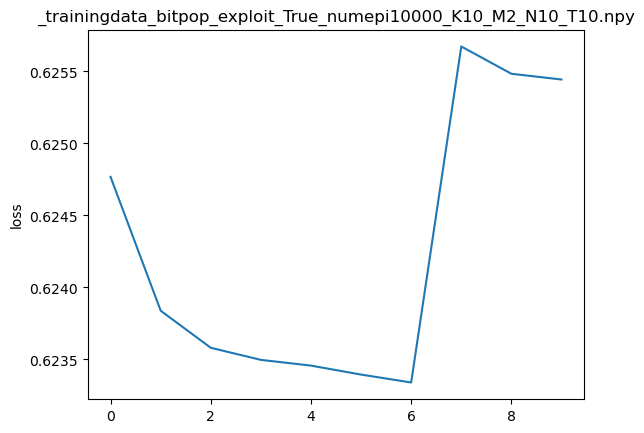

In [6]:
fig,ax=pl.subplots()
ax.plot(loss_data)
ax.set_title(data_filename)
ax.set_ylabel('loss')

Analyze datasets

In [7]:
states=np.array(data["states"][seed_idx]) #used only 1 seed
actions=np.array(data["actions"][seed_idx])
episode_times=np.array(data["times"][seed_idx])

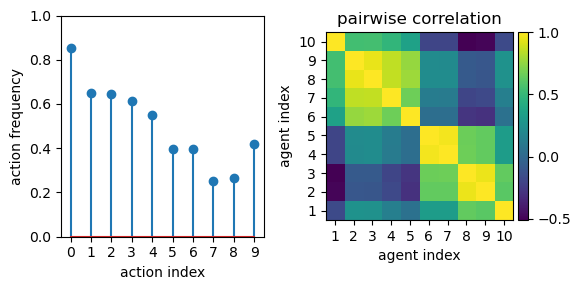

In [8]:
from utils import get_corr_matrix
fig,ax=pl.subplots(1,2,figsize=(6,3))
ax[0].stem(np.mean(actions,axis=0))
ax[0].set_ylim(0,1)
ax[0].set_xticks(range(num_agents))
ax[0].set_ylabel("action frequency")
ax[0].set_xlabel("action index")

corr_matrix = get_corr_matrix(data["actions"][0])
p=ax[1].imshow(corr_matrix, extent=[
                  0.5, num_agents+0.5, 0.5, num_agents+0.5])
ax[1].set_xticks(range(1,data['sys_parameters']['N']+1))
ax[1].set_yticks(range(1,data['sys_parameters']['N']+1))
ax[1].set_xlim(0.5, num_agents+0.5)
ax[1].set_ylim(0.5, num_agents+0.5)
ax[1].set_ylabel('agent index')
ax[1].set_xlabel('agent index')
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(p, cax=cax, orientation='vertical')
ax[1].set_title("pairwise correlation")
fig.tight_layout()

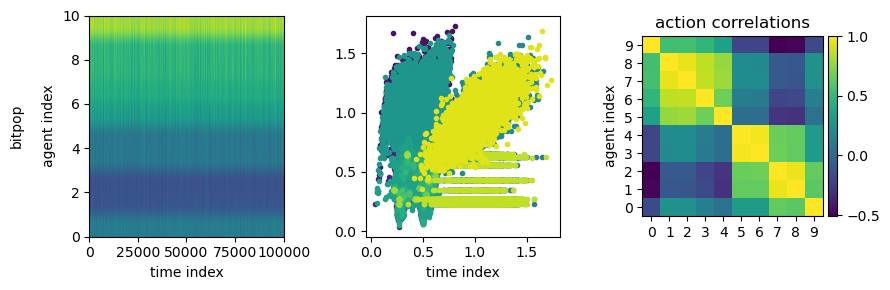

In [9]:
from utils import compare_plot
fig=compare_plot([outdir+data_filename])
fig.savefig(f'{data_filename[:-4]}_summary_fig.pdf', transparent=True, bbox_inches="tight", dpi=300)


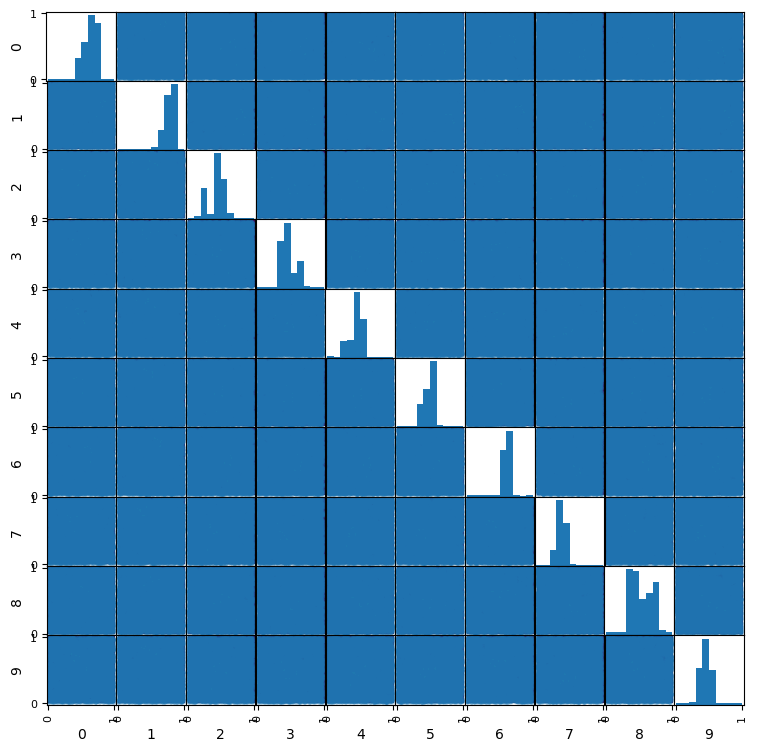

In [10]:
df = pd.DataFrame(states, columns=range(states.shape[1]))
axis_array=pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(9,9));
for rit,row in enumerate(axis_array):
    for cit,axis in enumerate(row):
        if rit!=cit:
            heatmap, xedges, yedges = np.histogram2d(states[:,rit], states[:,cit], bins=50)
            extent = [0, 1, 0, 1]
#             axis.remove()
            axis.imshow(heatmap.T, extent=extent, origin='lower')

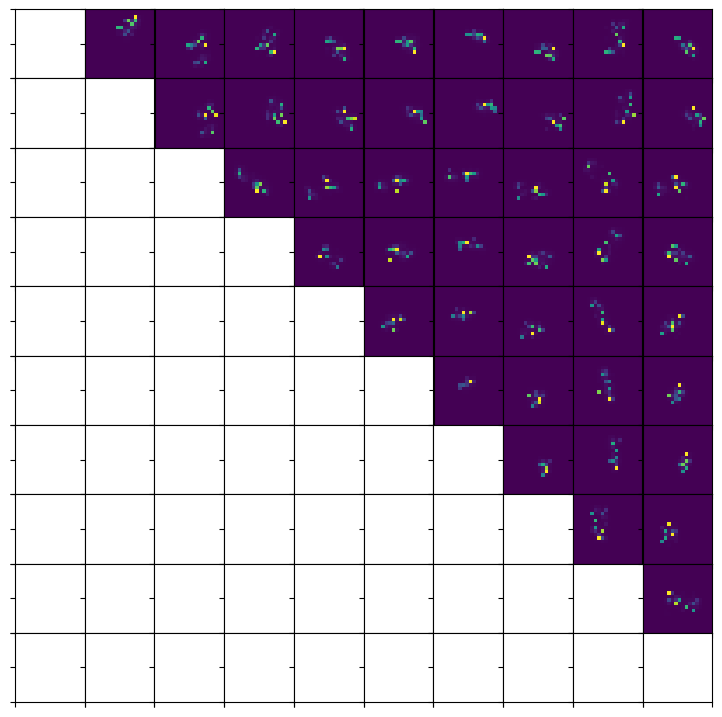

In [11]:
fig,ax=pl.subplots(*axis_array.shape,figsize=(9,9))
for rit,row in enumerate(axis_array):
    for cit,axis in enumerate(row):
        if rit<cit:
            heatmap, xedges, yedges = np.histogram2d(states[:,rit], states[:,cit], bins=20)
            extent = [0, 1, 0, 1]
#             axis.remove()
            ax[rit,cit].imshow(heatmap.T, extent=extent, origin='lower')
        ax[rit,cit].set_xticklabels([])
        ax[rit,cit].set_yticklabels([])
fig.subplots_adjust(wspace=0, hspace=0)
# fig.tight_layout()

In [12]:
# plot binned states
binned_df=(df>0.5)
outdf=binned_df.groupby(binned_df.columns.tolist(),as_index=False).size()/len(df)

/tmp/ipykernel_1694/3604754051.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([r'$10^{'+x.get_text()+'}$' for x in ax.get_xticklabels()]);


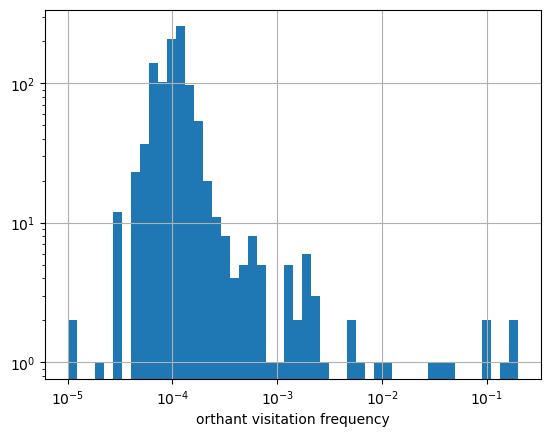

In [13]:
fig,ax=pl.subplots()
outdf['size'].apply(np.log10).hist(bins=50,ax=ax)
ax.set_xticklabels([r'$10^{'+x.get_text()+'}$' for x in ax.get_xticklabels()]);
ax.set_xlabel('orthant visitation frequency')
ax.set_yscale('log')